In [1]:
from itertools import zip_longest as zl
from collections import Counter
import os
import re

from matplotlib import font_manager, rc
from imutils.paths import list_files
import matplotlib.pyplot as plt
import geopandas as gpd
import requests as req
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
ROOT_PATH = '/'.join(os.getcwd().split('/')[:-2])
DATA_PATH = f'{ROOT_PATH}/doodle/data/geo'
FONT_PATH = f'{ROOT_PATH}/doodle/data/fonts/NanumMyeongjo.ttf'

## 차례대로 부산, 충북, 충남, 대구, 대전, 인천, 전북, 제주, 전남,
##        경북, 경기, 광주, 전남, 강원, 세종, 서울, 울산
PROVINCES = ['BS', 'CB', 'CN', 'DG', 'DJ', 'IC', 'JB', 'JJ','JN', 
             'KB', 'KG', 'KJ', 'KN', 'KW', 'SJ', 'SU', 'US']

In [3]:
## matplotlib에서 한글 폰트 사용하도록 해주는 부분
font = font_manager.FontProperties(fname = FONT_PATH).get_name()
rc('font', family = font)

In [4]:
## 리, 읍면동, 시군구 데이터 로딩 후 딕셔너리에 저장시킬 때 동일한 순서로 들어가지 않아 정렬시켜줌.
sorting_dict = lambda dict_: dict(sorted(dict_.items()))

## shp 파일 읽어서 지명만 모아주는 함수
def read_shp(path : str, region : str = 'dong') -> pd.Series: 
    
    if   region ==   'dong': name_col = 'EMD_NM'
    elif region ==  'towns': name_col = 'RI_NM'
    elif region == 'cities': name_col = 'SGG_NM'
    
    ## encoding = 'euc-kr'을 인자값으로 넣어주지 않으면 한글이 다 깨진다..
    return gpd.read_file(path, encoding = 'euc-kr')[name_col]


## 문자열 전처리 함수
def clear_str(string: str) -> str:
    
    ## 동네 이름에 을지로 3가, 종로 5가 처럼 **가가 붙어있는 녀석 중에서 동네 이름만 나오도록 수정
    string = re.compile('[0-9*]가').sub('', string)
    
    ## 문자열에서 한글이 아닌 녀석들은 제거하도록 처리 마지막 [:-1]은 **시, **동에서 시, 동, 구등 제거
    string = re.compile('[^가-힣*]').sub('', string)[:-1]
    string = string.replace('특별자치', '')
    
    ## 시군구 데이터에서 용인시 수지구, 용인시 기흥구처럼 같은 도시의 구만 다른 녀석들이 있어
    ## 그런 녀석들을 제거하기 위해 시로 분할 후, 붙여버림.
    return ''.join(string.split('시'))


## 데이터에서 지명 이름만 뽑아서 하나로 뭉친 데이터와 각 도, 광역시 별 몇 개의 
## 지명이 있는지 뽑아주는 함수.
def all_sectors(files: list) -> (str, dict):
    
    sectors     = ''
    num_sectors  = {file.split(os.path.sep)[-2] : 0 for file in files}
    
    for file in files:
        
        region   = file.split(os.path.sep)[-3]
        province = file.split(os.path.sep)[-2]
        
        sec      = read_shp(file, region = region).dropna()
        sec      = set([clear_str(s) for s in sec])
        sectors += ''.join(sec) 
        
        num_sectors[province] = len(sec)
    
    return sectors, num_sectors


## 데이터 별로 지명이 가장 많은 글자가 어느 지역에 있는지 계산해
## 데이터 프레임으로 만들어주는 함수. (이 함수는 좀 구데기여서 수정할 필요있음.)
def most_char_province(files: list, most_common : list) -> pd.DataFrame:
    
    ## 지역별로 가장 많이 나온 지명의 글자 수 만큼 0으로 초기화 시켜줌.
    num_province = {province : [0 for _ in most_common] for province in PROVINCES}
    
    for file in files:
        
        region = file.split(os.path.sep)[-3]
        province = file.split(os.path.sep)[-2]
        
        ## 파일 불러온 후에 전처리
        sec = read_shp(file, region = region).dropna()
        sec = set([clear_str(s) for s in sec])
        sec = ''.join(sec)
        
        for idx, most in enumerate(most_common):
            
            ## 각 지역별로 가장 많이 나온 글자의 자리에 글자의 개수만큼 더해줌.
            num_province[province][idx] += sec.count(most[0])
    
    indexes  = [c[0] for c in most_common] 
    return pd.DataFrame(num_province, index = indexes)


def make_dirs(region = 'dong'):
    
    [os.makedirs(f'{DATA_PATH}/{region}/{province}', exist_ok = True) 
     for province in PROVINCES]
    

## 가장 많이 나온 상위 20%들의 글자 합이 전체 데이터의 몇 %인지 계산해주는 함수
def ratio_calculator(string, all_cnt):
    
    
    string_cnt = Counter(string)
    
    ## 글자수 상위 20%에 해당하는 녀석들만 모은 데이터
    top_20p    = string_cnt.most_common(len(all_cnt) // 5)
    
    sum_top20p = sum([top[1] for top in top_20p])
    sum_allcnt = sum([all for all in all_cnt.values()])
    
    return sum_top20p / sum_allcnt, sum_top20p, sum_allcnt 


## 히트맵과 분포 그래프를 보여주도록 하는 함수
def show_figure(data, is_percentage = False):
    
    ## 데이터 프레임인 경우에는 히트맵을, 딕셔너리인 경우에는 분포 그래프를 보여줌.
    if isinstance(data, pd.DataFrame):
        
        plt.figure(figsize = (16, 5))
        
        ## 퍼센테이지를 표시할 경우엔 True, 아닌경우엔 False
        if is_percentage:
            sns.heatmap(data.div(data.sum(axis = 1), axis = 0),
                        cmap = 'BuPu', linewidths = .8, annot = True, fmt = '.2%')
            
        else:
            sns.heatmap(data, cmap = 'BuPu', annot = True, fmt = 'g')
            
            
    else:
        plt.figure(figsize = (30, 10))
        plt.bar(data.keys(), data.values())
        

In [5]:
make_dirs()
make_dirs(region = 'cities')
make_dirs(region =  'towns')

In [6]:
town_files       = [path for path in list_files(f'{DATA_PATH}/towns') if path.split('.')[-1] == 'shp']
towns, num_towns = all_sectors(town_files)
towns_cnt        = sorted(Counter(towns).items(), key = lambda x: x[1], reverse = True)
most_towns       = towns_cnt[:10]
towns_cnt        = dict(towns_cnt)
num_towns        = sorting_dict(num_towns)
num_towns, most_towns

({'BS': 62,
  'CB': 1157,
  'CN': 1524,
  'DG': 90,
  'IC': 121,
  'JB': 1155,
  'JJ': 117,
  'JN': 1765,
  'KB': 2025,
  'KG': 1204,
  'KN': 1404,
  'KW': 999,
  'SJ': 112,
  'SU': 19,
  'US': 114},
 [('산', 717),
  ('곡', 578),
  ('동', 500),
  ('천', 485),
  ('대', 473),
  ('신', 447),
  ('정', 441),
  ('성', 367),
  ('상', 354),
  ('평', 343)])

In [7]:
most_town_df = most_char_province(town_files, most_towns)
most_town_df

,BS,CB,CN,DG,DJ,IC,JB,JJ,JN,KB,KG,KJ,KN,KW,SJ,SU,US
산,3,64,91,8,0,10,87,8,114,105,68,0,89,51,11,0,8
곡,3,68,68,9,0,0,45,0,68,114,56,0,78,53,11,0,5
동,4,51,66,2,0,4,51,5,109,60,44,0,52,44,2,0,6
천,6,41,60,8,0,1,39,7,64,89,40,0,54,56,2,5,13
대,2,49,74,5,0,3,45,5,55,70,46,0,61,42,6,2,8
신,2,42,79,2,0,7,54,11,52,73,55,0,37,22,6,2,3
정,1,45,71,3,0,7,45,1,70,58,40,0,56,33,6,1,4
성,2,44,60,2,0,4,40,8,61,63,26,0,35,15,6,0,1
상,0,36,35,2,0,5,34,8,47,69,32,0,38,43,1,0,4
평,3,45,38,2,0,2,29,5,53,57,31,0,47,26,2,0,3


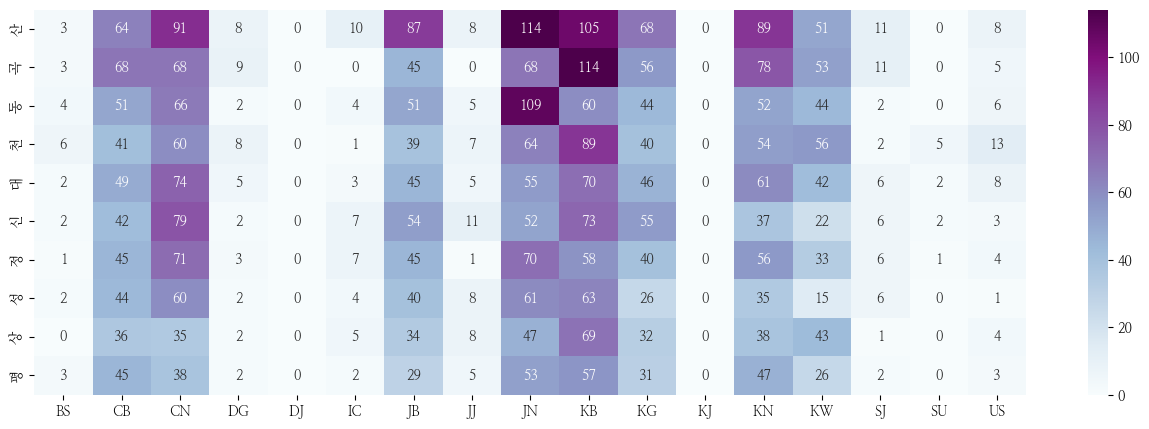

In [8]:
show_figure(most_town_df)

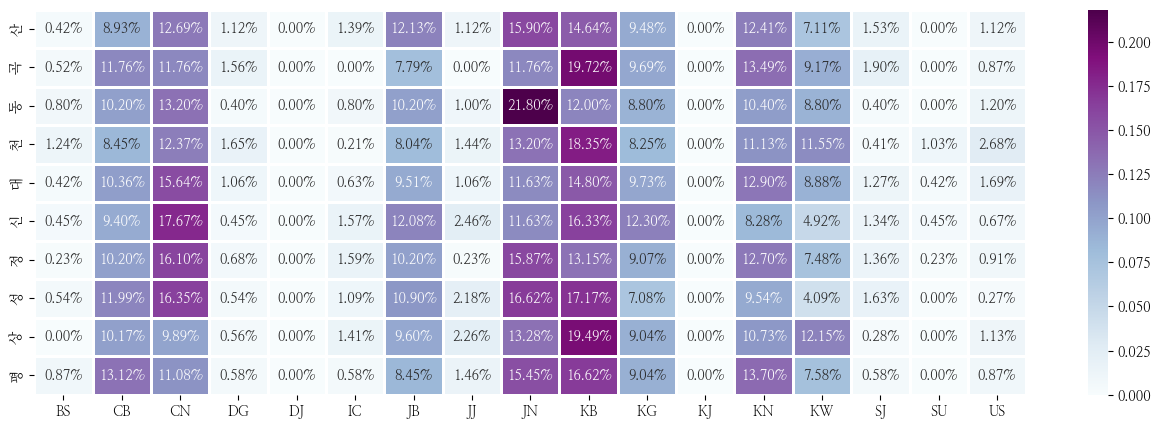

In [9]:
show_figure(most_town_df, is_percentage = True)

In [10]:
ratio, sum_town20p, sum_townall = ratio_calculator(towns, towns_cnt)
f'{ratio * 100:.3f} %'

'73.254 %'

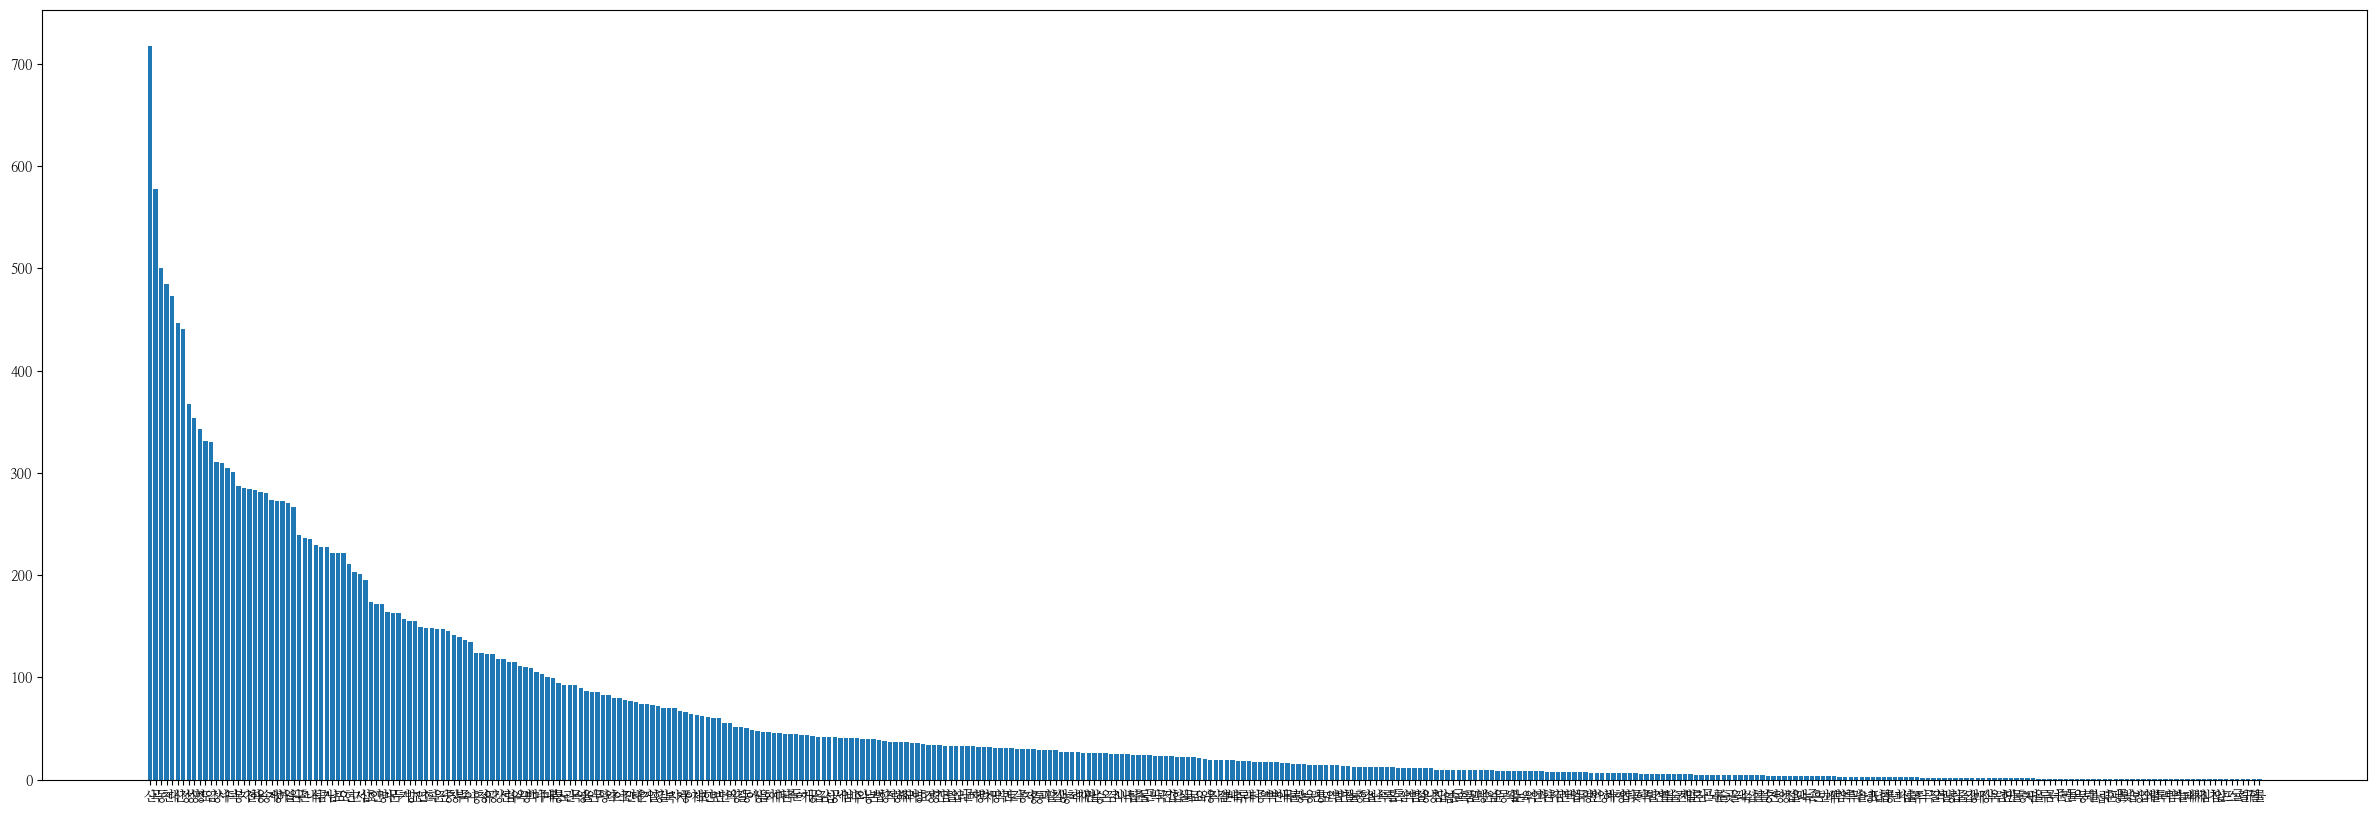

In [11]:
show_figure(towns_cnt)

In [12]:
sum_town20p, sum_townall, 0.8 * sum_townall

(17321, 23645, 18916.0)

In [13]:
dong_files         = [path for path in list_files(f'{DATA_PATH}/dong') if path.split('.')[-1] == 'shp']
dongs, num_dongs   = all_sectors(dong_files)
dongs_cnt          = sorted(Counter(dongs).items(), key = lambda x: x[1], reverse = True)
most_dongs         = dongs_cnt[:10]
dongs_cnt          = dict(dongs_cnt)
num_dongs          = sorting_dict(num_dongs)

num_dongs, most_dongs

({'BS': 133,
  'CB': 231,
  'CN': 272,
  'DG': 176,
  'DJ': 171,
  'IC': 131,
  'JB': 347,
  'JJ': 73,
  'JN': 376,
  'KB': 500,
  'KG': 670,
  'KJ': 185,
  'KN': 474,
  'KW': 269,
  'SJ': 33,
  'SU': 357,
  'US': 84},
 [('산', 326),
  ('신', 183),
  ('성', 178),
  ('남', 176),
  ('천', 171),
  ('대', 170),
  ('동', 167),
  ('곡', 158),
  ('정', 156),
  ('서', 134)])

In [14]:
most_dong_df = most_char_province(dong_files, most_dongs)
most_dong_df

,BS,CB,CN,DG,DJ,IC,JB,JJ,JN,KB,KG,KJ,KN,KW,SJ,SU,US
산,4,16,28,15,10,7,35,1,35,38,47,21,28,19,1,14,7
신,6,11,16,10,12,5,16,1,9,16,25,8,14,7,0,23,4
성,4,18,24,12,8,2,17,1,10,24,13,2,21,9,1,7,5
남,6,13,11,4,3,5,9,3,14,26,20,9,24,13,1,11,4
천,8,12,16,9,3,2,12,2,10,25,23,3,18,13,0,11,4
대,11,7,12,12,10,2,5,2,15,18,23,7,28,6,1,9,2
동,7,9,6,9,0,3,15,1,15,23,22,5,25,14,2,7,4
곡,3,8,12,6,3,4,4,0,13,18,29,8,24,10,1,11,4
정,5,9,9,3,11,2,16,2,7,14,24,7,16,9,2,13,7
서,3,8,5,9,1,5,16,3,13,17,17,4,14,5,1,8,5


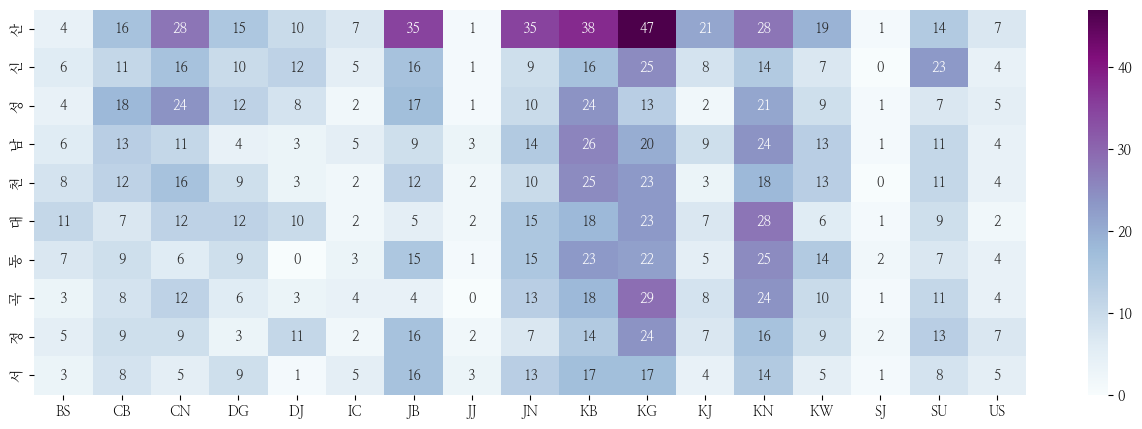

In [15]:
show_figure(most_dong_df)

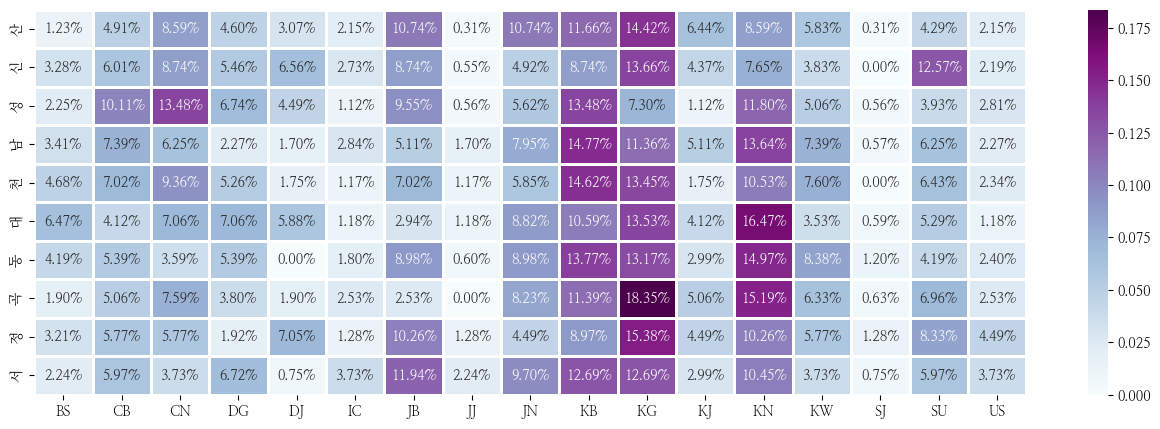

In [16]:
show_figure(most_dong_df, is_percentage = True)

In [17]:
ratio, sum_dong20p, sum_dongall = ratio_calculator(dongs, dongs_cnt)
f'{ratio * 100:.3f} %'

'71.887 %'

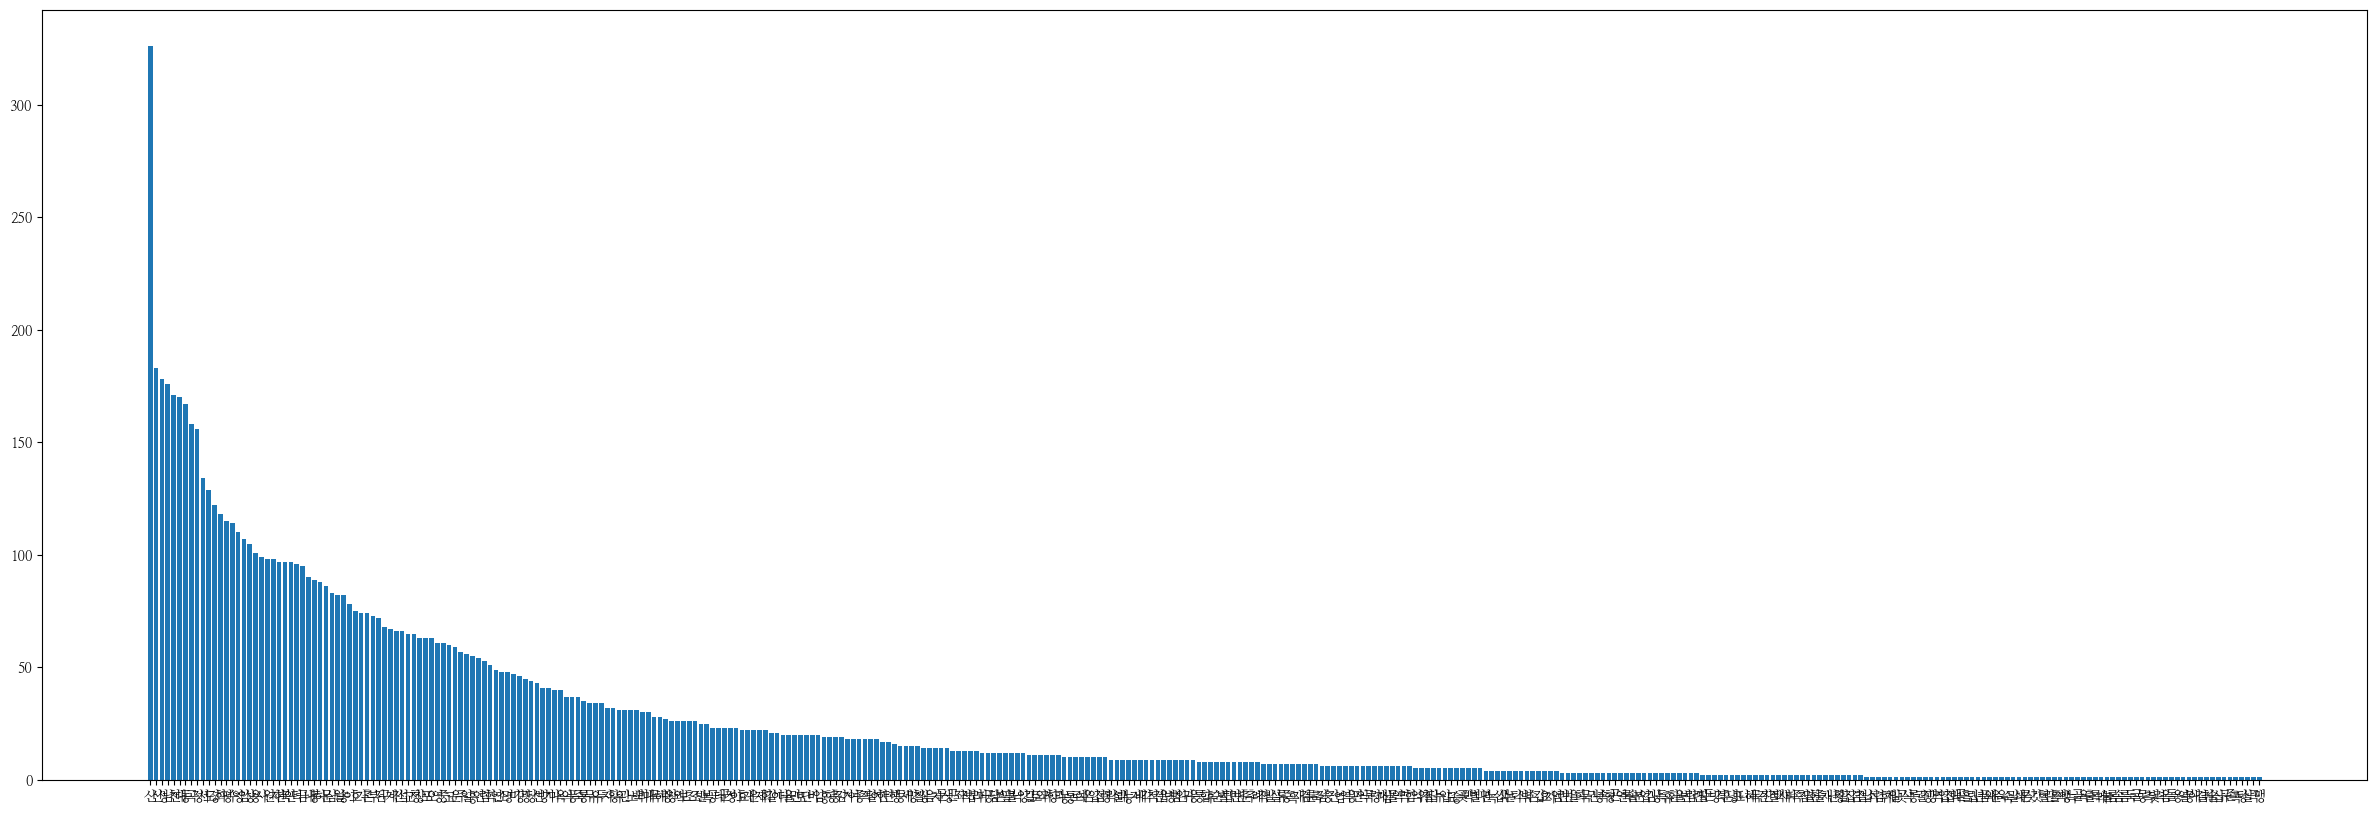

In [18]:
show_figure(dongs_cnt)

In [19]:
sum_dong20p, sum_dongall, 0.8 * sum_dongall

(6385, 8882, 7105.6)

In [20]:
city_files         = [path for path in list_files(f'{DATA_PATH}/cities') if path.split('.')[-1] == 'shp']
cities, num_cities = all_sectors(city_files)
num_cities         = sorting_dict(num_cities)


## 상기한 내용대로 **시 @@구에서 **@@로 남은 중복된 녀석들을 제거해주는 부분
## e.g.) 용인시 수지구 - 전처리 -> 용인수지 - 이부분 -> 수지
## 마지막에는 **시는 추가되어야 하므로, 마지막 과정에서 추가해줌.
not_uniques = [
               '천안', '청주', '안양', '고양', 
               '성남', '용인', '수원', '성남', 
               '안산', '창원'
              ]
for not_unique in not_uniques: 
    cities = cities.replace(not_unique, '') + not_unique
    
cities_cnt = sorted(Counter(cities).items(), 
                    key = lambda x: x[1], reverse = True)

most_cities = cities_cnt[:10]
cities_cnt  = dict(cities_cnt)
num_cities, most_cities

({'BS': 16,
  'CB': 15,
  'CN': 16,
  'DG': 8,
  'DJ': 5,
  'IC': 10,
  'JB': 15,
  'JJ': 2,
  'JN': 22,
  'KB': 24,
  'KG': 42,
  'KJ': 5,
  'KN': 22,
  'KW': 18,
  'SJ': 1,
  'SU': 25,
  'US': 5},
 [('산', 22),
  ('천', 21),
  ('주', 21),
  ('양', 20),
  ('동', 20),
  ('성', 19),
  ('서', 16),
  ('남', 14),
  ('안', 14),
  ('영', 13)])

In [21]:
most_city_df = most_char_province(city_files, most_cities)
most_city_df

,BS,CB,CN,DG,DJ,IC,JB,JJ,JN,KB,KG,KJ,KN,KW,SJ,SU,US
산,1,1,5,0,0,0,3,0,0,1,5,1,5,0,0,1,0
천,0,3,3,0,0,0,0,0,1,3,6,0,2,3,0,2,0
주,0,4,1,0,0,0,4,1,1,4,5,0,1,1,0,0,1
양,0,1,1,0,0,1,0,0,2,1,9,0,3,3,0,1,0
동,2,1,1,1,1,2,0,0,0,1,3,1,1,1,0,4,1
성,0,1,1,2,1,0,0,0,3,2,5,0,2,2,0,2,0
서,2,1,3,2,1,1,0,1,0,0,1,1,0,0,0,3,0
남,1,0,1,1,0,1,1,0,1,1,5,1,1,0,0,1,1
안,0,0,3,0,0,0,2,0,2,1,8,0,1,0,0,0,0
영,2,1,0,0,0,0,0,0,2,4,1,0,1,1,0,1,0


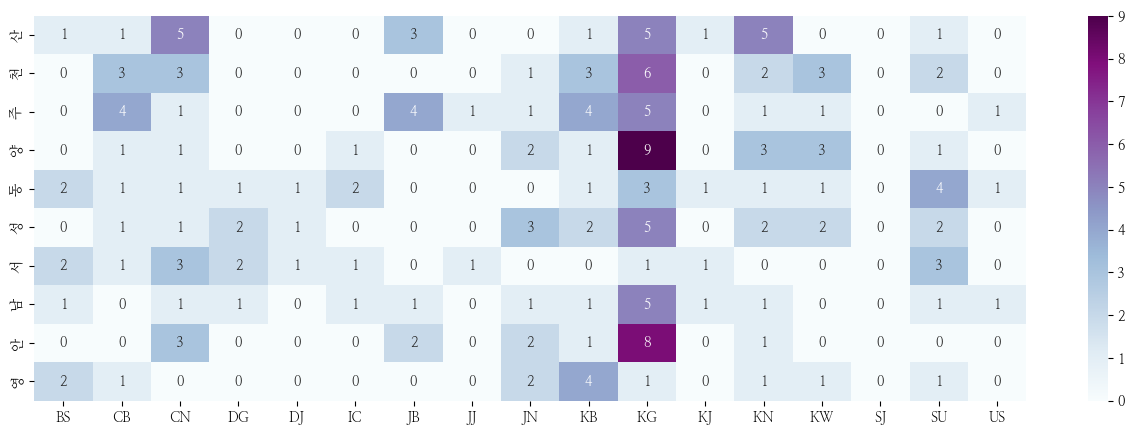

In [22]:
show_figure(most_city_df)

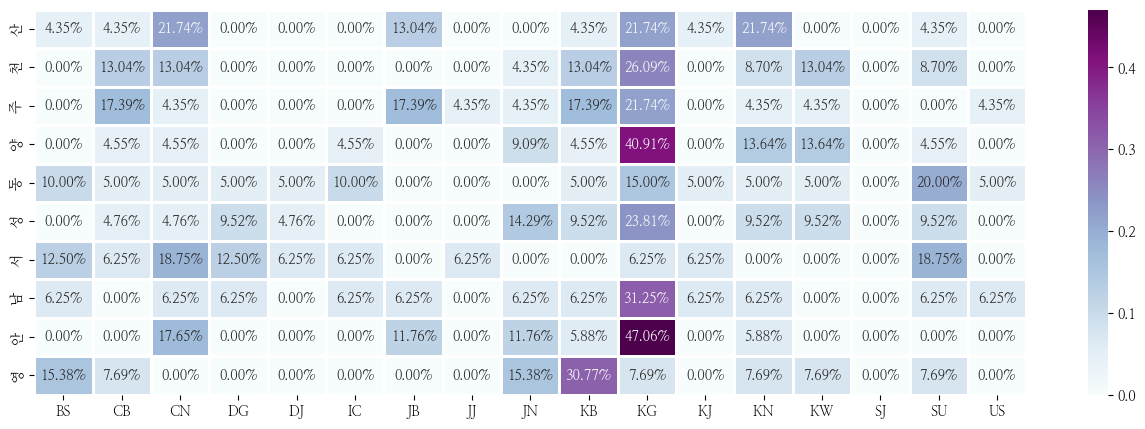

In [23]:
show_figure(most_city_df, is_percentage = True)

In [24]:
ratio, sum_cities20p, sum_citiesall = ratio_calculator(cities, cities_cnt)
f'{ratio * 100:.3f} %'

'60.271 %'

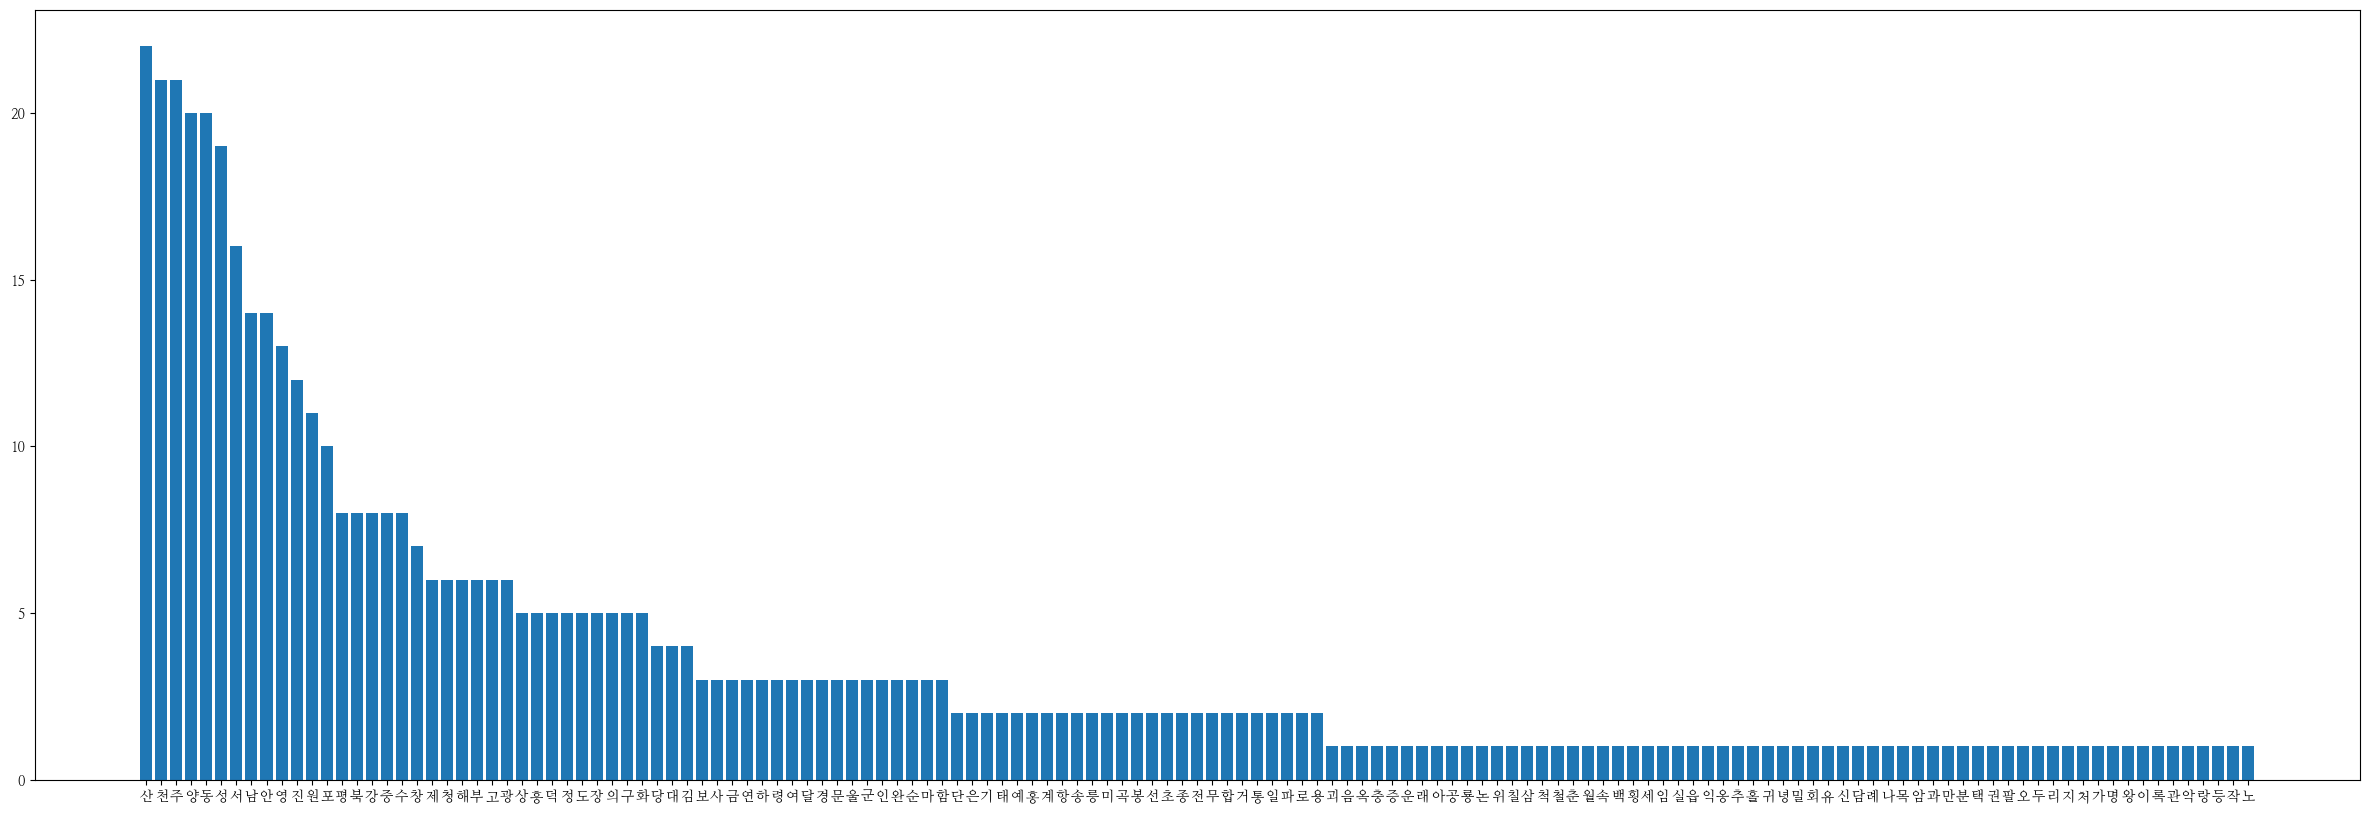

In [25]:
show_figure(cities_cnt)

In [26]:
sum_cities20p, sum_citiesall, 0.8 * sum_citiesall

(311, 516, 412.8)

In [27]:
## 읍면동, 시군구, 리 데이터를 모두 모아서 모든 행정구역에는 어떤 글자가 가장 많을지 분석
string   = towns + dongs + cities 

## 리 데이터 셋에는 대전, 광주 데이터가 없어 itertools의 zip_longest로 기본값을 0으로 하여 사용
iterator = zl(num_towns.values(), num_dongs.values(), num_cities.values(), fillvalue = 0)
num_all  = {province : (nt + nd + nc) for province, (nt, nd, nc) in zip(PROVINCES, iterator)}

all_cnt  = sorted(Counter(towns).items(), key = lambda x: x[1], reverse = True)
most_all = all_cnt[:10]
all_cnt  = dict(all_cnt)
num_all, most_all

({'BS': 211,
  'CB': 1403,
  'CN': 1812,
  'DG': 274,
  'DJ': 297,
  'IC': 1296,
  'JB': 479,
  'JJ': 1840,
  'JN': 2423,
  'KB': 1728,
  'KG': 2116,
  'KJ': 1189,
  'KN': 608,
  'KW': 306,
  'SJ': 148,
  'SU': 382,
  'US': 89},
 [('산', 717),
  ('곡', 578),
  ('동', 500),
  ('천', 485),
  ('대', 473),
  ('신', 447),
  ('정', 441),
  ('성', 367),
  ('상', 354),
  ('평', 343)])

In [28]:
all_files     = town_files + dong_files + city_files
most_df       = most_char_province(all_files, most_towns)
most_df

,BS,CB,CN,DG,DJ,IC,JB,JJ,JN,KB,KG,KJ,KN,KW,SJ,SU,US
산,8,81,124,23,10,17,125,9,149,144,120,22,122,70,12,15,15
곡,6,76,80,15,3,4,49,0,82,133,85,8,102,63,12,11,9
동,13,61,73,12,1,9,66,6,124,84,69,6,78,59,4,11,11
천,14,56,79,17,3,3,51,9,75,117,69,3,74,72,2,18,17
대,14,56,86,17,11,5,50,7,70,88,69,7,89,48,7,13,10
신,8,53,95,12,12,12,70,12,62,89,80,8,51,29,6,25,7
정,7,54,80,6,11,9,62,3,77,72,66,7,72,43,8,14,11
성,6,63,85,16,9,6,57,9,74,89,44,2,58,26,7,9,6
상,1,42,38,8,5,8,46,10,52,85,50,0,52,50,1,9,7
평,7,54,40,7,6,7,35,9,64,73,52,2,60,37,3,6,4


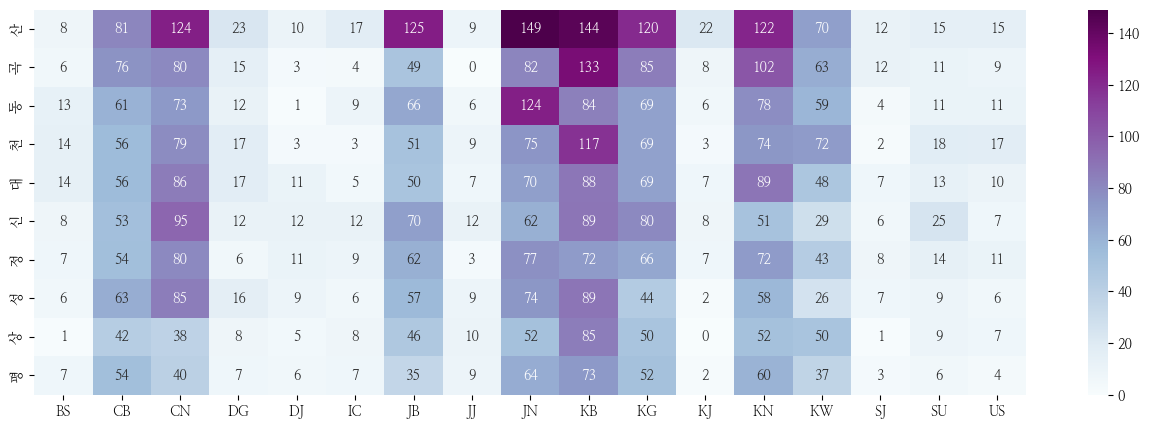

In [29]:
show_figure(most_df)

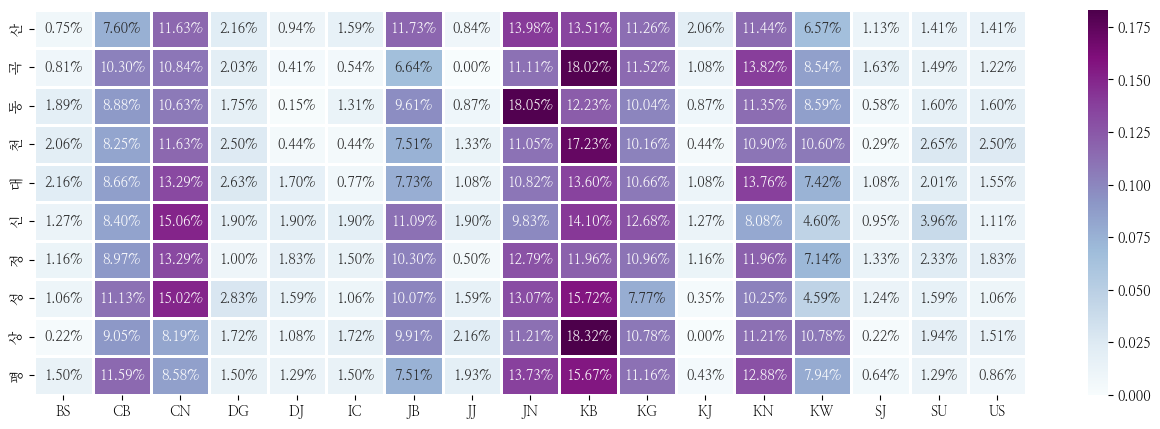

In [30]:
show_figure(most_df, is_percentage = True)

In [31]:
ratio, sum_all20p, sum_all = ratio_calculator(string, all_cnt)
f'{ratio * 100:.3f} %'

'102.280 %'

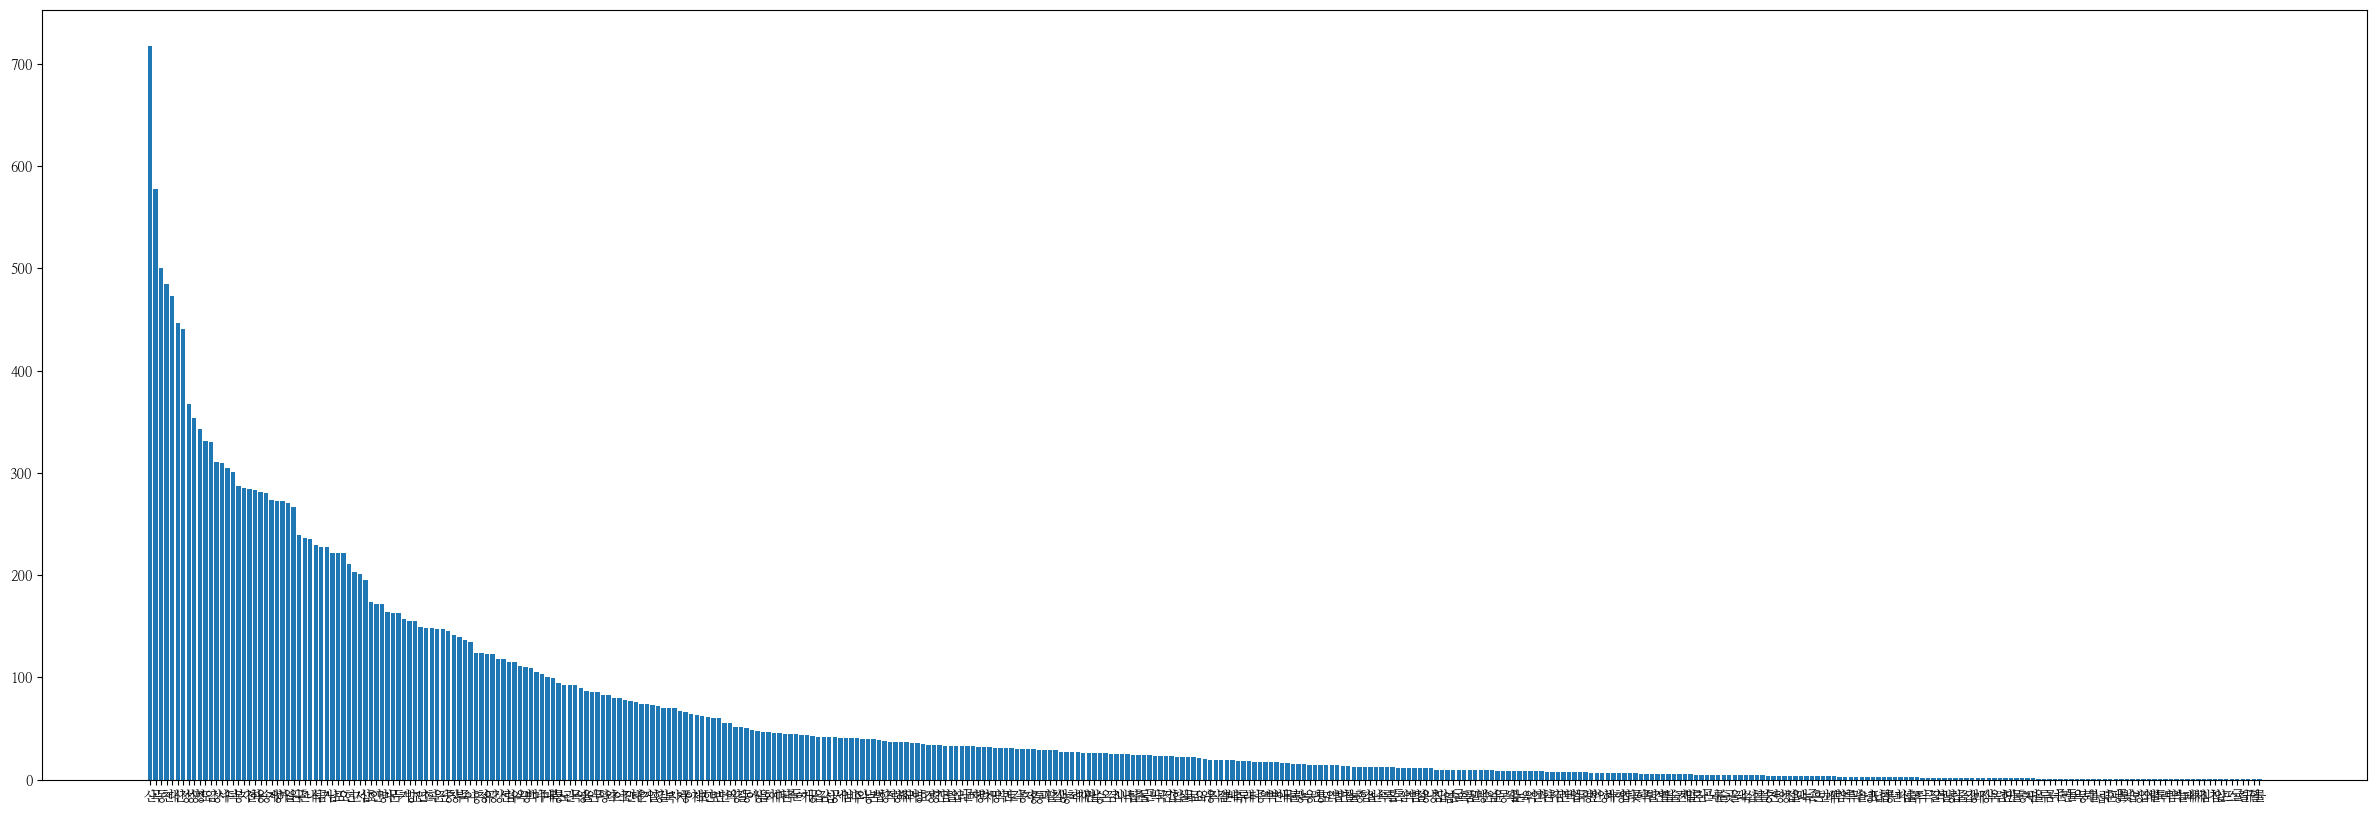

In [32]:
show_figure(all_cnt)

In [33]:
sum_all20p, sum_all, sum_all * 0.8

(24184, 23645, 18916.0)